# Group 7
# ADS 504 Summer 2024

In [ ]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the data

file_path = "/content/drive/MyDrive/ADS504/project/nvda_2018.csv"

#file_path = "/workspaces/ADS-504-02-Group-7-Machine-Learning-and-Deep-Learning-for-Data-Science/nvda_2018.csv"
data = pd.read_csv(file_path)

## TEST. Ensure data shows for given file_path. Comment out ones not unique to you.

In [ ]:
data.head()

,time,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,...,ImpulseMACDCDSignal,RSI,Regular Bullish,Regular Bullish Label,Hidden Bullish,Hidden Bullish Label,Regular Bearish,Regular Bearish Label,Hidden Bearish,Hidden Bearish Label
0,1510086600,5.2830,5.30175,5.28300,5.30025,5.2830,5.30175,5.28300,5.30025,4.462440,...,0.057289,69.475334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1510151400,5.2950,5.29825,5.21275,5.23525,5.2950,5.29825,5.21275,5.23525,4.464509,...,0.052901,51.395830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1510155000,5.2355,5.26125,5.23000,5.23675,5.2355,5.26125,5.23000,5.23675,4.465430,...,0.045753,51.708145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1510158600,5.2360,5.24300,5.18225,5.21825,5.2360,5.24300,5.18225,5.21825,4.466655,...,0.034023,47.642077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1510162200,5.2155,5.22200,5.18750,5.20150,5.2155,5.22200,5.18750,5.20150,4.467462,...,0.022199,44.249339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature engineering.
### Convert original UNIX 'time' to datetime object

In [ ]:
#Convert UNIX time to datetime object
data['time'] = pd.to_datetime(data['time'], unit='s')

### Add feature. Day of the week.

In [ ]:
#Feature Engineering. Day of the week.
data['day_of_week'] = data['time'].dt.day_name()
data.insert(1, 'day_of_week', data.pop('day_of_week'))

### Convert from UTC time to America/New_York time (where NYSE trades)

In [ ]:
#Convert to New York time (Where NYSE trades)
data['time'] = data['time'].dt.tz_localize('GMT')
data['time'] = data['time'].dt.tz_convert('America/New_York')

### Add feature. Morning / Afternoon categories.

In [ ]:
#Feature Engineering. Morning/Afternoon
data['session'] = data['time'].dt.hour.apply(lambda x:
                                             'Morning' if x<12 else 'Afternoon')
data.insert(2, 'session', data.pop('session'))

### Add feature. Target = closing price = opening price

In [ ]:
# Feature Engineering
data["target"] = data["close"] - data["open"]


### Add feature. Target_t+1 to be used as "forecasted" value. Use as model evaluation metric using RMSE. Penalize larger errors greater.

In [ ]:
data["target_t+1"] = data["target"].shift(-1)


### Checkpoint. Post-Feature Engineering.

In [ ]:
data.head()

,time,day_of_week,session,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),...,Regular Bullish,Regular Bullish Label,Hidden Bullish,Hidden Bullish Label,Regular Bearish,Regular Bearish Label,Hidden Bearish,Hidden Bearish Label,target,target_t+1
0,2017-11-07 15:30:00-05:00,Tuesday,Afternoon,5.2830,5.30175,5.28300,5.30025,5.2830,5.30175,5.28300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01725,-0.05975
1,2017-11-08 09:30:00-05:00,Wednesday,Morning,5.2950,5.29825,5.21275,5.23525,5.2950,5.29825,5.21275,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.05975,0.00125
2,2017-11-08 10:30:00-05:00,Wednesday,Morning,5.2355,5.26125,5.23000,5.23675,5.2355,5.26125,5.23000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00125,-0.01775
3,2017-11-08 11:30:00-05:00,Wednesday,Morning,5.2360,5.24300,5.18225,5.21825,5.2360,5.24300,5.18225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.01775,-0.01400
4,2017-11-08 12:30:00-05:00,Wednesday,Afternoon,5.2155,5.22200,5.18750,5.20150,5.2155,5.22200,5.18750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.01400,0.00950


## EDA

### Explore cardinality and remove null or columns with no variation (1 or 0 cardinality)

In [ ]:
cardinality = data.nunique()

# Remove columns with 1 or 0 cardinality
col_keep = cardinality[cardinality > 1].index
data = data[col_keep]
data.nunique()

,0
time,11751
day_of_week,5
session,2
open,10722
high,10554
low,10592
close,10605
PlotCandle (Open),10722
PlotCandle (High,10554
PlotCandle (Low),10592


## EDA. Visualization.

### Price

<Axes: >

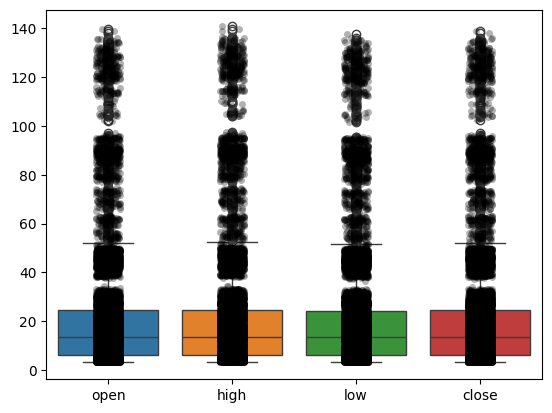

In [ ]:
sns.boxplot(data = data[['open', 'high', 'low', 'close']])
sns.stripplot(data = data[['open', 'high', 'low', 'close']], jitter=True, color='black', alpha = 0.3)

Many outliers present in price. Should handle with appropriate method (clipping) to minimize affect on standard deviation and mean.

### Regular Bullish/Bearish Value Distribution

Text(0.5, 1.0, 'Regular Bullish vs Regular Bearish')

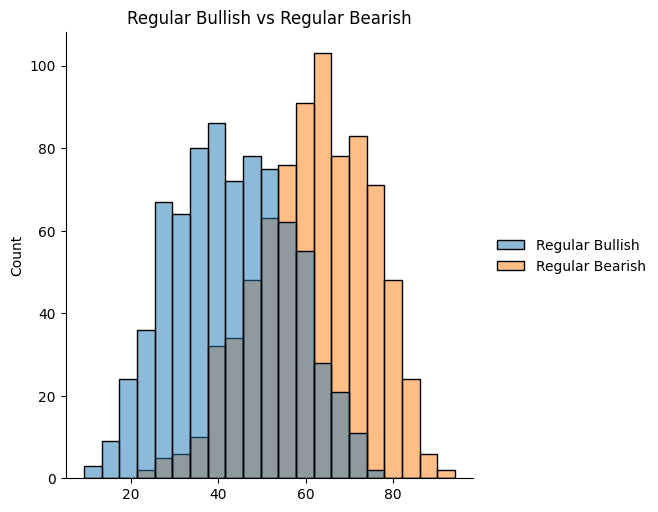

In [ ]:
df = pd.DataFrame(data)
sns.displot(df[['Regular Bullish', 'Regular Bearish']])
plt.title('Regular Bullish vs Regular Bearish')

## Data Cleaning. Handle outliers with clipping.

In [ ]:
num_cols = data.select_dtypes(include=[np.number])

Q1 = num_cols.quantile(.25)
Q3 = num_cols.quantile(.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

num_cols_clipped = num_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)
data = num_cols_clipped.join(data.drop(columns=num_cols.columns))

## Checkpoint. Post-Data Cleaning: Clipped.



In [ ]:
data.head()

,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,Upper Band #1,...,Regular Bullish Label,Hidden Bullish,Regular Bearish,Regular Bearish Label,Hidden Bearish,target,target_t+1,time,day_of_week,session
0,5.2830,5.30175,5.28300,5.30025,5.2830,5.30175,5.28300,5.30025,4.462440,4.817839,...,NaN,NaN,NaN,NaN,NaN,0.01725,-0.05975,2017-11-07 15:30:00-05:00,Tuesday,Afternoon
1,5.2950,5.29825,5.21275,5.23525,5.2950,5.29825,5.21275,5.23525,4.464509,4.821719,...,NaN,NaN,NaN,NaN,NaN,-0.05975,0.00125,2017-11-08 09:30:00-05:00,Wednesday,Morning
2,5.2355,5.26125,5.23000,5.23675,5.2355,5.26125,5.23000,5.23675,4.465430,4.823430,...,NaN,NaN,NaN,NaN,NaN,0.00125,-0.01775,2017-11-08 10:30:00-05:00,Wednesday,Morning
3,5.2360,5.24300,5.18225,5.21825,5.2360,5.24300,5.18225,5.21825,4.466655,4.825640,...,NaN,NaN,NaN,NaN,NaN,-0.01775,-0.01400,2017-11-08 11:30:00-05:00,Wednesday,Morning
4,5.2155,5.22200,5.18750,5.20150,5.2155,5.22200,5.18750,5.20150,4.467462,4.827079,...,NaN,NaN,NaN,NaN,NaN,-0.01400,0.00950,2017-11-08 12:30:00-05:00,Wednesday,Afternoon


### Plot boxplots of outlier-handled data

<Axes: >

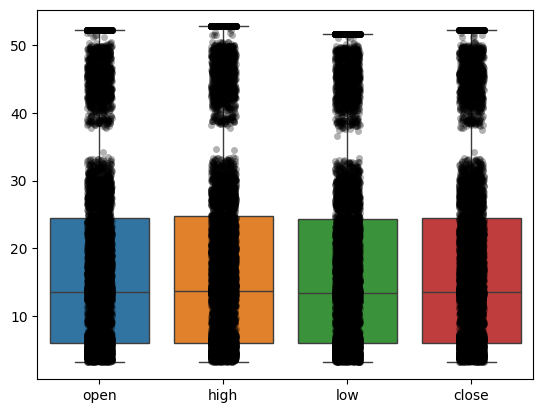

In [ ]:
sns.boxplot(data = data[['open', 'high', 'low', 'close']])
sns.stripplot(data = data[['open', 'high', 'low', 'close']], jitter=True, color='black', alpha = 0.3)

In [ ]:
data.describe()

,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,Upper Band #1,...,ImpulseMACDCDSignal,RSI,Regular Bullish,Regular Bullish Label,Hidden Bullish,Regular Bearish,Regular Bearish Label,Hidden Bearish,target,target_t+1
count,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,11751.000000,...,11751.000000,11751.000000,773.000000,47.000000,773.000000,782.000000,109.000000,782.000000,11751.000000,11750.000000
mean,18.521895,18.655232,18.388390,18.523754,18.521895,18.655232,18.388390,18.523754,18.211374,19.380870,...,0.050324,52.770201,43.045584,31.902592,43.045584,62.113744,69.486574,62.113744,0.002949,0.002946
std,15.407151,15.540164,15.276932,15.408749,15.407151,15.540164,15.276932,15.408749,15.112916,16.240988,...,0.231509,13.969243,13.221043,6.096085,13.221043,12.638289,6.544558,12.638289,0.111392,0.111417
min,3.141750,3.150750,3.113500,3.141250,3.141750,3.150750,3.113500,3.141250,3.631566,3.809856,...,-0.359548,12.378961,9.412335,18.297603,9.412335,26.616331,52.464690,26.616331,-0.205781,-0.205859
25%,6.033375,6.057000,5.997562,6.032375,6.033375,6.057000,5.997562,6.032375,5.972547,6.194836,...,-0.048948,42.734248,33.100232,27.723527,33.100232,53.625506,65.183786,53.625506,-0.049313,-0.049344
50%,13.536000,13.604250,13.449000,13.532000,13.536000,13.604250,13.449000,13.532000,13.272913,13.803004,...,0.004333,53.183313,42.593023,32.480574,42.593023,62.786525,69.126650,62.786525,0.001250,0.001250
75%,24.505000,24.743000,24.267500,24.508500,24.505000,24.743000,24.267500,24.508500,23.953340,26.118768,...,0.158118,62.971106,52.825179,35.909946,52.825179,71.631623,73.663184,71.631623,0.055000,0.055000
max,52.212438,52.772000,51.672406,52.222687,52.212438,52.772000,51.672406,52.222687,50.924529,56.004666,...,0.468717,93.326393,77.615040,48.189576,77.615040,94.098040,85.971551,94.098040,0.211469,0.211516


## Data Cleaning. Handle missing values.

In [ ]:
# Use forward fill as it is logical for previous known value to carry forward
data.fillna(method="ffill", inplace=True)

<ipython-input-21-ee18d535629b>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)


In [ ]:
# Correct column names
correct_column_names = [
    "time",
    "day_of_week",
    "session",
    "open",
    "high",
    "low",
    "close",
    "PlotCandle (Open)",
    "PlotCandle (High)",
    "PlotCandle (Low)",
    "PlotCandle (Close)",
    "VWAP",
    "Upper Band #1",
    "Lower Band #1",
    "Upper Band #2",
    "Lower Band #2",
    "Upper Band #3",
    "Lower Band #3",
    "MidLine",
    "ImpulseMACD",
    "ImpulseHisto",
    "ImpulseMACDSignal",
    "RSI",
    "Regular Bullish Label",
    "Regular Bullish",
    "Hidden Bullish Label",
    "Hidden Bullish",
    "Regular Bearish Label",
    "Regular Bearish",
    "Hidden Bearish Label",
    "Hidden Bearish",
]

In [ ]:
# Lag Features
for lag in range(1, 4):
    data[f"close_lag_{lag}"] = data["close"].shift(lag)

# Rolling Statistics
data["close_rolling_mean_5"] = data["close"].rolling(window=5).mean()
data["close_rolling_std_5"] = data["close"].rolling(window=5).std()

In [ ]:
data.columns

Index(['open', 'high', 'low', 'close', 'PlotCandle (Open)', 'PlotCandle (High',
       'PlotCandle (Low)', 'PlotCandle (Close)', 'VWAP', 'Upper Band #1',
       'Lower Band #1', 'Upper Band #2', 'Lower Band #2', 'Upper Band #3',
       'Lower Band #3', 'ImpulseMACD', 'ImpulseHisto', 'ImpulseMACDCDSignal',
       'RSI', 'Regular Bullish', 'Regular Bullish Label', 'Hidden Bullish',
       'Regular Bearish', 'Regular Bearish Label', 'Hidden Bearish', 'target',
       'target_t+1', 'time', 'day_of_week', 'session', 'close_lag_1',
       'close_lag_2', 'close_lag_3', 'close_rolling_mean_5',
       'close_rolling_std_5'],
      dtype='object')

In [ ]:
# Drop unused columns
columns_to_drop = [
    "Regular Bullish",
    "Regular Bullish Label",
    "Hidden Bullish",
    "Regular Bearish",
    "Regular Bearish Label",
    "Hidden Bearish",
]
data.drop(columns=columns_to_drop, inplace=True)

# Convert categorical features to numerical
data = pd.get_dummies(
    data, columns=["day_of_week", "session"], drop_first=True
)

# Create the target variable: close - open
data["target"] = data["close"] - data["open"]
data["target_t+1"] = data["target"].shift(-1)

# Handle NaN introduced by the shift
data.dropna(subset=["target_t+1"], inplace=True)

# Extract features and target variable
X = data.drop(columns=["time", "close", "target", "target_t+1"])
y = data["target_t+1"]

In [ ]:
from sklearn.impute import SimpleImputer

# Ensure alignment of X and y
X = X.iloc[:-1]
y = y.iloc[:-1]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
}

random_search_xgb = RandomizedSearchCV(
    xgb_model, param_grid_xgb, n_iter=10, cv=3, scoring="r2", n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, GRU, Input, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

# Assuming X_train_scaled, X_test_scaled, y_train, y_test, and random_search_xgb are already defined

# Initialize models
lr_model = LinearRegression()
best_rf_model = RandomForestRegressor(random_state=42)
best_xgb_model = xgb.XGBRegressor(**random_search_xgb.best_params_)

# Train models
lr_model.fit(X_train_scaled, y_train)
best_rf_model.fit(X_train_scaled, y_train)
best_xgb_model.fit(X_train_scaled, y_train)

# Evaluate models
lr_predictions = lr_model.predict(X_test_scaled)
rf_predictions = best_rf_model.predict(X_test_scaled)
xgb_predictions = best_xgb_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# FFNN Model
def create_ffnn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train the FFNN model
ffnn_model = create_ffnn_model()
ffnn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the FFNN model
ffnn_predictions = ffnn_model.predict(X_test_scaled)
ffnn_mse = mean_squared_error(y_test, ffnn_predictions)
ffnn_r2 = r2_score(y_test, ffnn_predictions)

# LSTM Model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Reshape input to be [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Create and train the LSTM model
lstm_model = create_lstm_model()
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the LSTM model
lstm_predictions = lstm_model.predict(X_test_reshaped)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

# CNN Model
def create_cnn_model():
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], 1)))
    model.add(Conv1D(64, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Reshape input to be [samples, features, channels]
X_train_cnn_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Create and train the CNN model
cnn_model = create_cnn_model()
cnn_model.fit(X_train_cnn_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the CNN model
cnn_predictions = cnn_model.predict(X_test_cnn_reshaped)
cnn_mse = mean_squared_error(y_test, cnn_predictions)
cnn_r2 = r2_score(y_test, cnn_predictions)

# GRU Model
def create_gru_model():
    model = Sequential()
    model.add(Input(shape=(1, X_train_scaled.shape[1])))
    model.add(GRU(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train the GRU model
gru_model = create_gru_model()
gru_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the GRU model
gru_predictions = gru_model.predict(X_test_reshaped)
gru_mse = mean_squared_error(y_test, gru_predictions)
gru_r2 = r2_score(y_test, gru_predictions)

# Transformer Model
def create_transformer_model():
    inputs = Input(shape=(1, X_train_scaled.shape[1]))
    attention = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    attention = LayerNormalization(epsilon=1e-6)(attention)
    attention = Flatten()(attention)
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# Create and train the Transformer model
transformer_model = create_transformer_model()
transformer_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the Transformer model
transformer_predictions = transformer_model.predict(X_test_reshaped)
transformer_predictions = transformer_predictions.reshape(-1, 1)  # Reshape to 2D array
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_r2 = r2_score(y_test, transformer_predictions)

print(f"Linear Regression MSE: {lr_mse}, R2: {lr_r2}")
print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")
print(f"Best XGBoost Parameters: {random_search_xgb.best_params_}")
print(f"FFNN MSE: {ffnn_mse}, R2: {ffnn_r2}")
print(f"LSTM MSE: {lstm_mse}, R2: {lstm_r2}")
print(f"CNN MSE: {cnn_mse}, R2: {cnn_r2}")
print(f"GRU MSE: {gru_mse}, R2: {gru_r2}")
print(f"Transformer MSE: {transformer_mse}, R2: {transformer_r2}")

# Cross-Validation Scores
cv_scores_xgb = cross_val_score(
    best_xgb_model, X_train_scaled, y_train, cv=5, scoring="r2", n_jobs=-1
)
print(f"XGBoost 5-fold CV R2: {np.mean(cv_scores_xgb)}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


53/74 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Linear Regression MSE: 0.03266695492983303, R2: -0.024921559034823515
Random Forest MSE: 0.0344291357316553, R2: -0.08020975772320216
XGBoost MSE: 0.03201285435032616, R2: -0.004399236487351743
Best XGBoost Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}
FFNN MSE: 0.04516007590159594, R2: -0.4168916416792956
LSTM MSE: 0.03956183881933308, R2: -0.24124766474530168
CNN MSE: 0.032491500926589534, R2: -0.01941671198282613
GRU MSE: 0.03799049822608898, R2: -0.19194705334574746
Transformer MSE: 0.031982797128253936, R2: -0.0034561949650337986


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


XGBoost 5-fold CV R2: -0.0020804249196019866


In [ ]:
import pandas as pd

# Define model names and their respective MSE and R-squared values
models = ["Linear Regression", "Random Forest", "XGBoost", "FFNN", "LSTM", "CNN", "GRU", "Transformer"]
mse_values = [lr_mse, rf_mse, xgb_mse, ffnn_mse, lstm_mse, cnn_mse, gru_mse, transformer_mse]
r2_values = [lr_r2, rf_r2, xgb_r2, ffnn_r2, lstm_r2, cnn_r2, gru_r2, transformer_r2]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": models,
    "MSE": mse_values,
    "R-squared": r2_values
})

# Print the results table
print(results_df)


               Model       MSE  R-squared
0  Linear Regression  0.032667  -0.024922
1      Random Forest  0.034429  -0.080210
2            XGBoost  0.032013  -0.004399
3               FFNN  0.045160  -0.416892
4               LSTM  0.039562  -0.241248
5                CNN  0.032492  -0.019417
6                GRU  0.037990  -0.191947
7        Transformer  0.031983  -0.003456


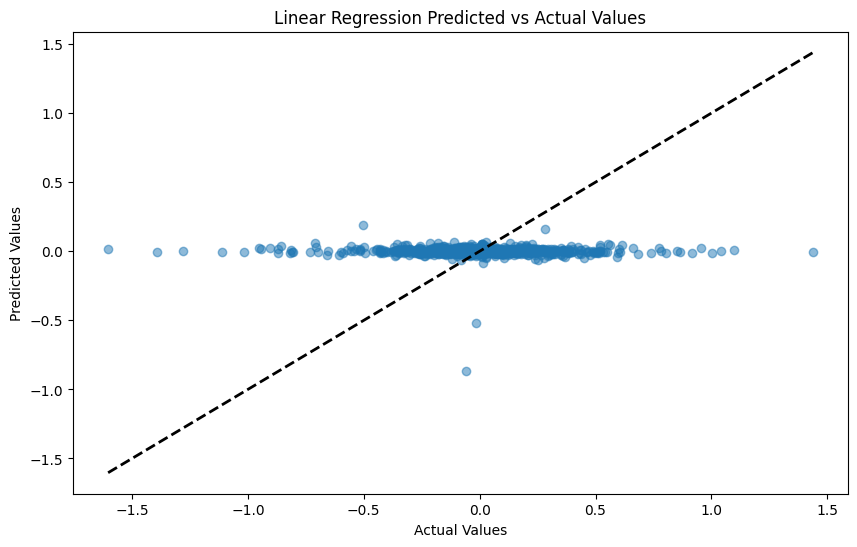

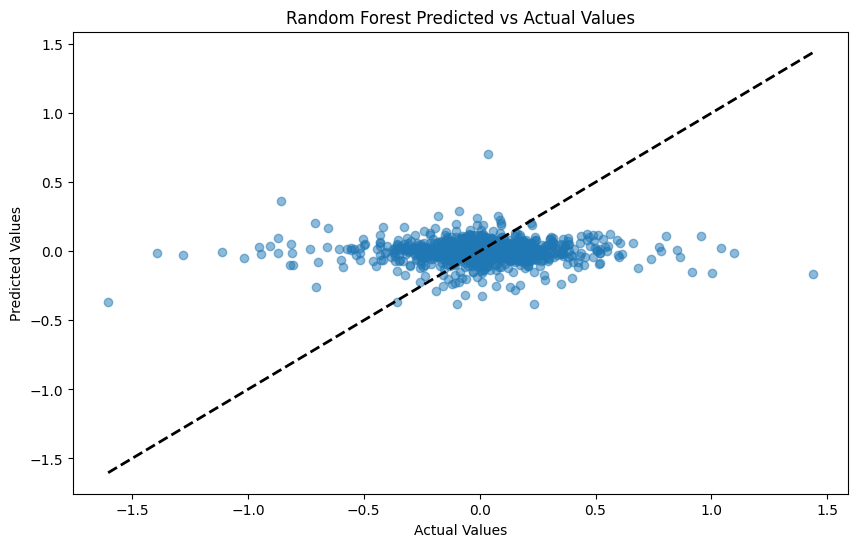

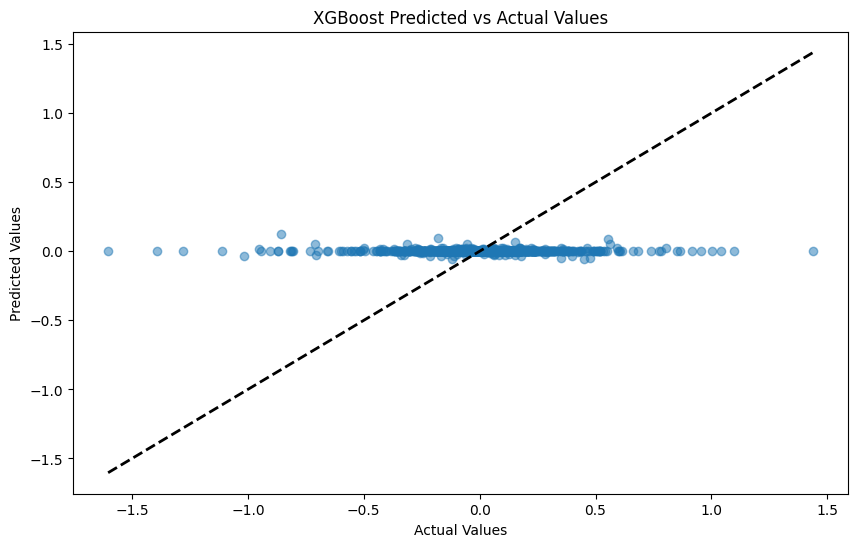

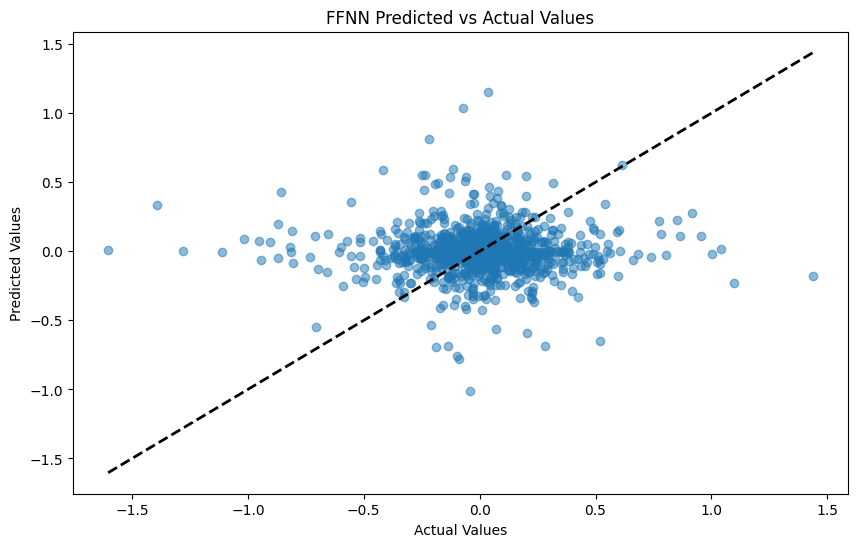

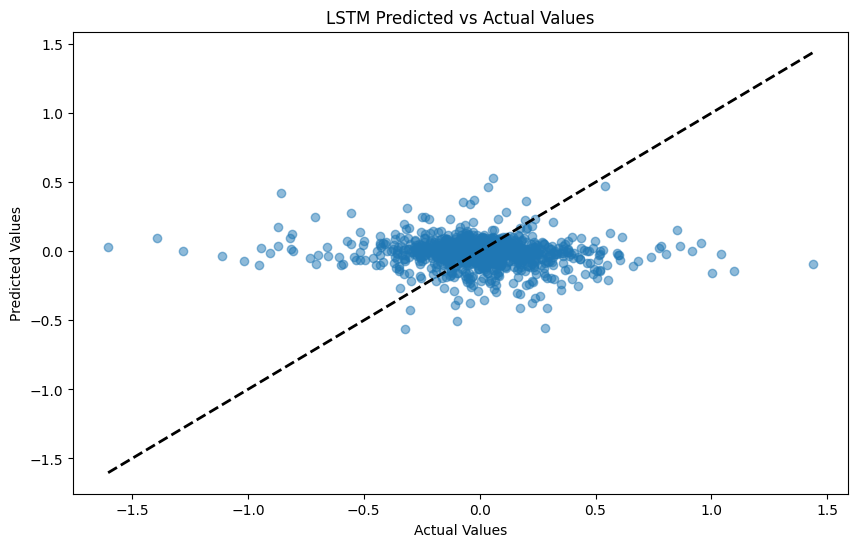

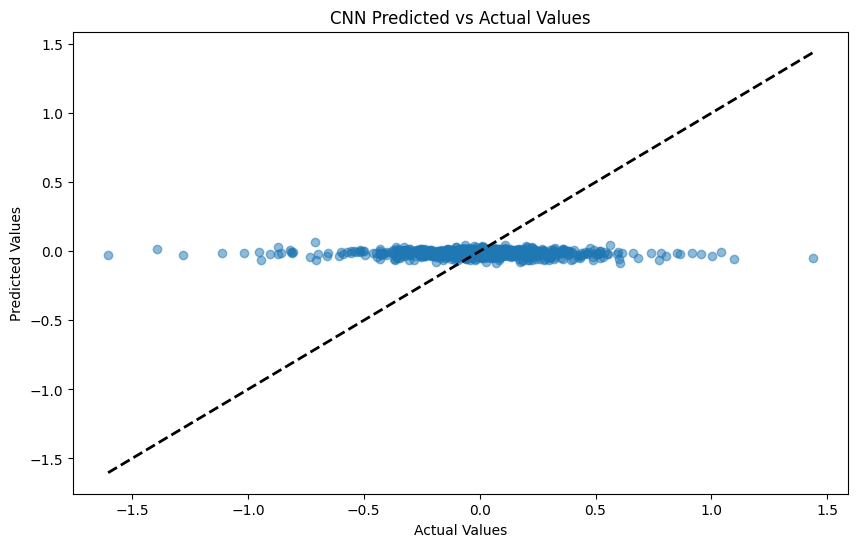

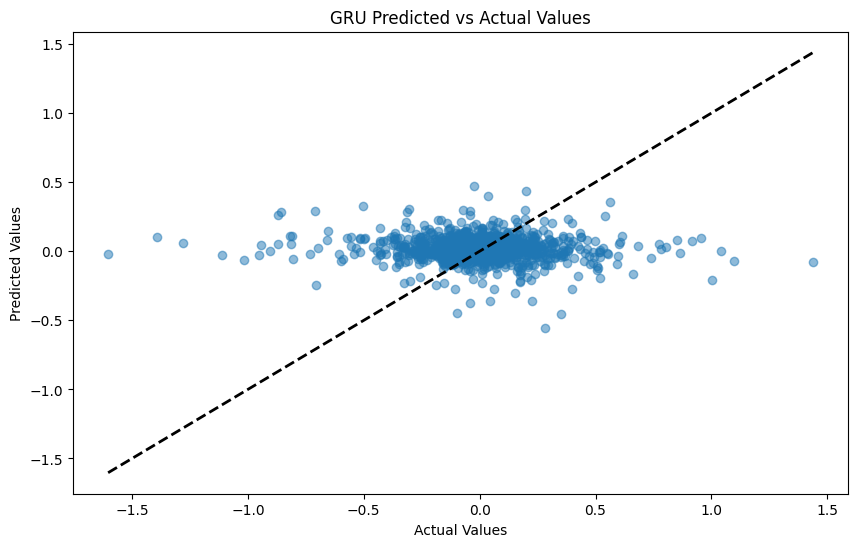

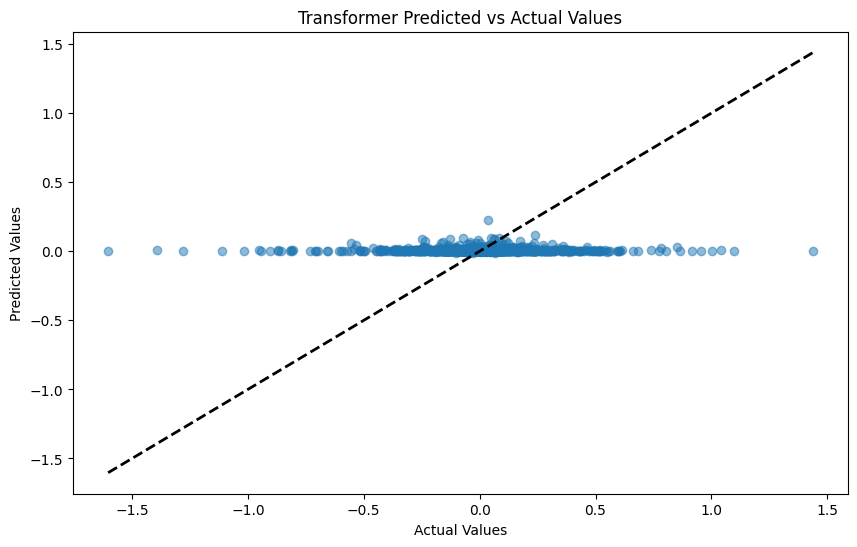

In [ ]:
# Scatter Plots of predicted vs. actual values

import matplotlib.pyplot as plt

# Function to plot predicted vs actual values
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Predicted vs Actual Values')
    plt.show()

# Plot predictions for each model
plot_predictions(y_test, lr_predictions, 'Linear Regression')
plot_predictions(y_test, rf_predictions, 'Random Forest')
plot_predictions(y_test, xgb_predictions, 'XGBoost')
plot_predictions(y_test, ffnn_predictions, 'FFNN')
plot_predictions(y_test, lstm_predictions, 'LSTM')
plot_predictions(y_test, cnn_predictions, 'CNN')
plot_predictions(y_test, gru_predictions, 'GRU')
plot_predictions(y_test, transformer_predictions, 'Transformer')


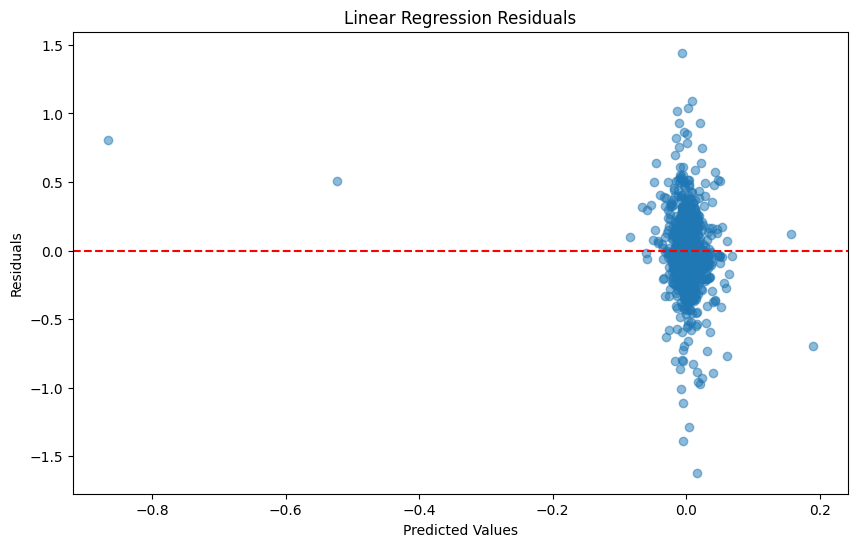

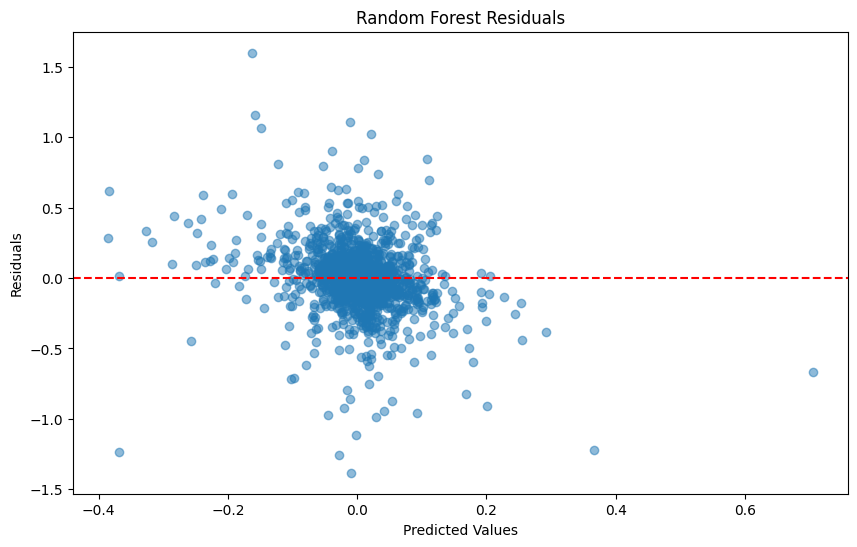

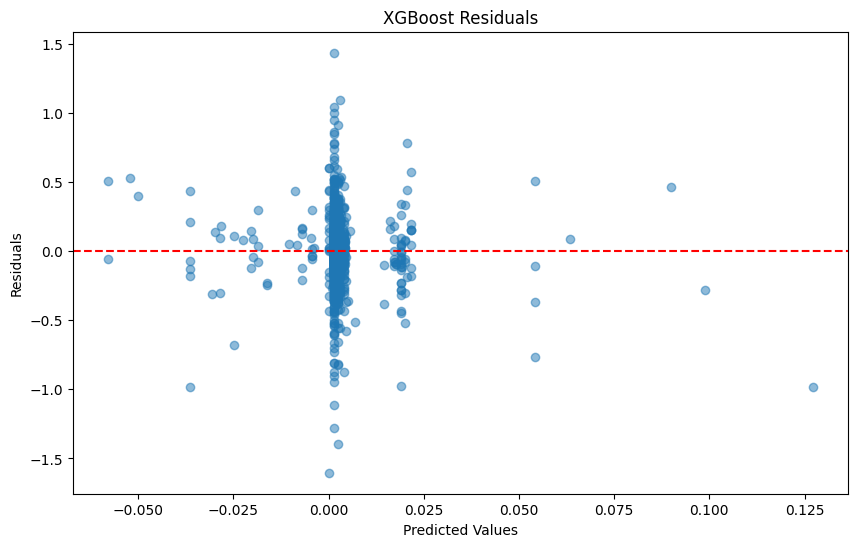

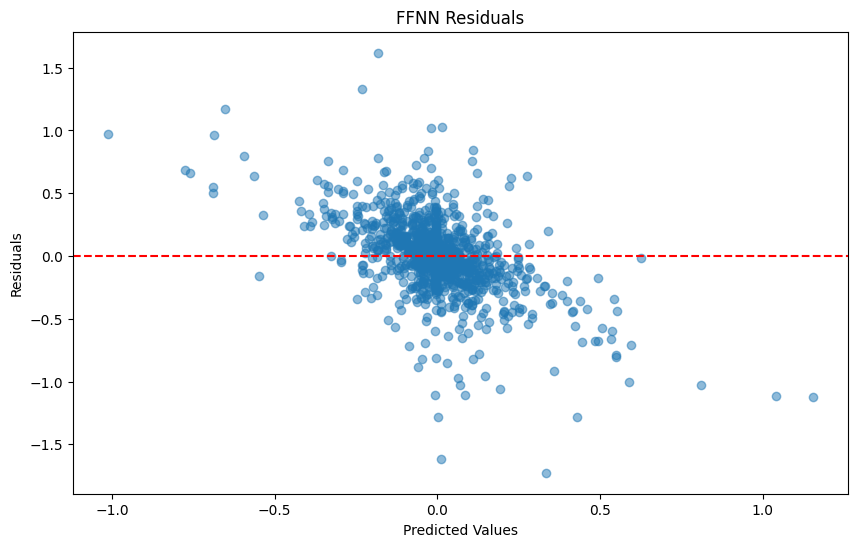

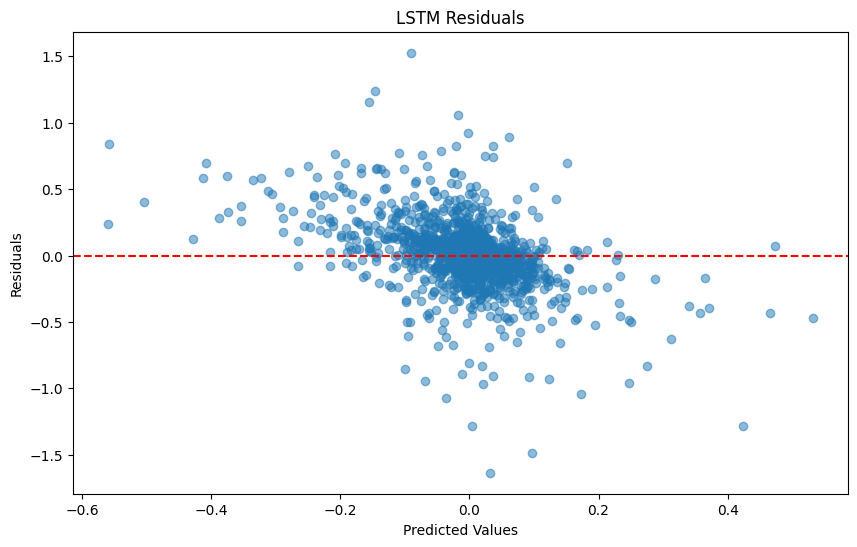

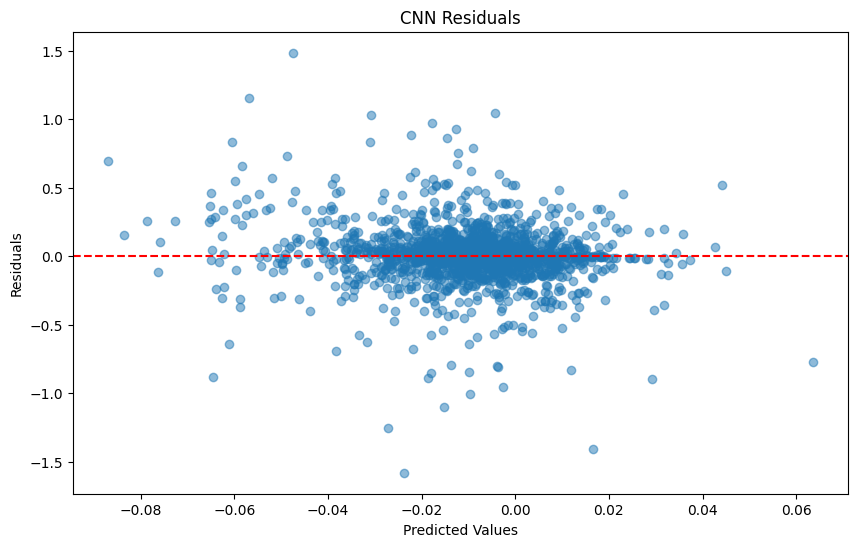

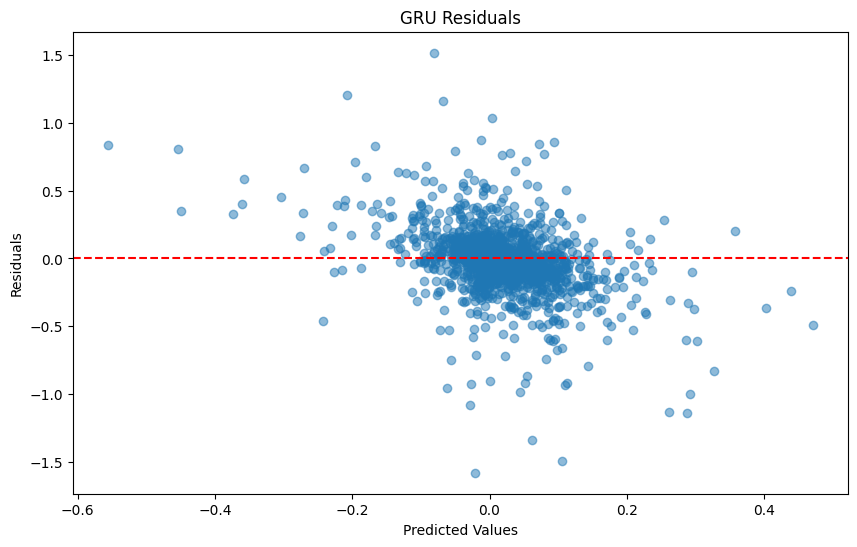

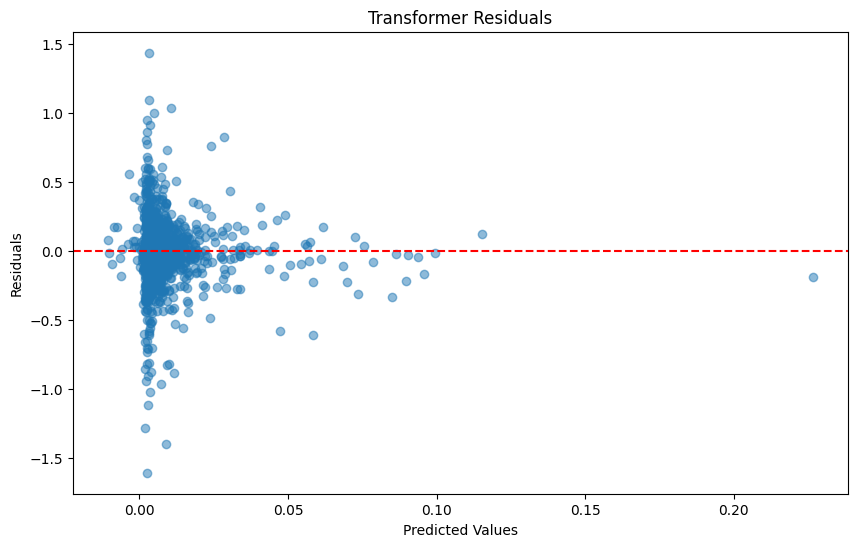

In [ ]:
# Residual Plots to analyze the errors (residuals).

import matplotlib.pyplot as plt

# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residuals')
    plt.show()

# Plot residuals for each model
plot_residuals(y_test, lr_predictions, 'Linear Regression')
plot_residuals(y_test, rf_predictions, 'Random Forest')
plot_residuals(y_test, xgb_predictions, 'XGBoost')
plot_residuals(y_test, ffnn_predictions.flatten(), 'FFNN')
plot_residuals(y_test, lstm_predictions.flatten(), 'LSTM')
plot_residuals(y_test, cnn_predictions.flatten(), 'CNN')
plot_residuals(y_test, gru_predictions.flatten(), 'GRU')
plot_residuals(y_test, transformer_predictions.flatten(), 'Transformer')


<ipython-input-34-49c65453977d>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
<ipython-input-34-49c65453977d>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
<ipython-input-34-49c65453977d>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')


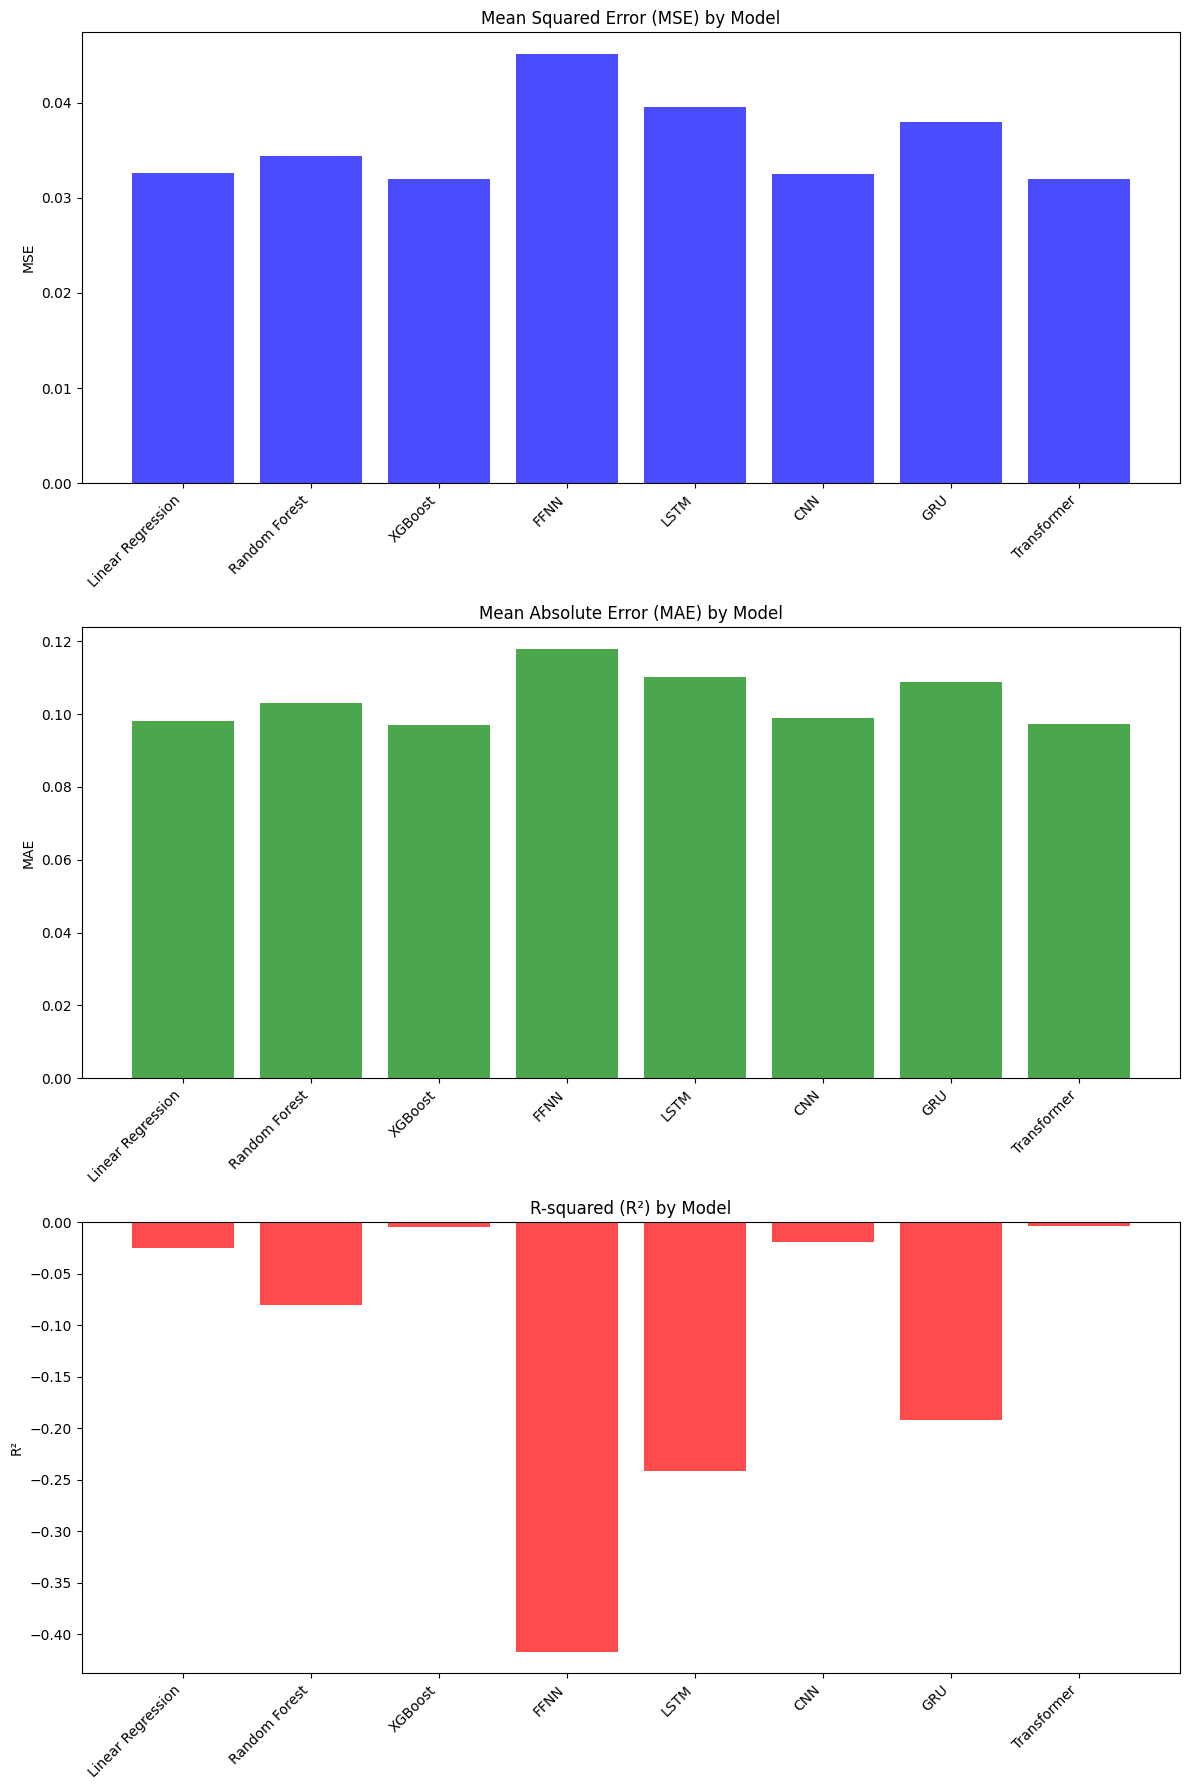

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate performance metrics
metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'FFNN', 'LSTM', 'CNN', 'GRU', 'Transformer'],
    'MSE': [
        mean_squared_error(y_test, lr_predictions),
        mean_squared_error(y_test, rf_predictions),
        mean_squared_error(y_test, xgb_predictions),
        mean_squared_error(y_test, ffnn_predictions.flatten()),
        mean_squared_error(y_test, lstm_predictions.flatten()),
        mean_squared_error(y_test, cnn_predictions.flatten()),
        mean_squared_error(y_test, gru_predictions.flatten()),
        mean_squared_error(y_test, transformer_predictions.flatten())
    ],
    'MAE': [
        mean_absolute_error(y_test, lr_predictions),
        mean_absolute_error(y_test, rf_predictions),
        mean_absolute_error(y_test, xgb_predictions),
        mean_absolute_error(y_test, ffnn_predictions.flatten()),
        mean_absolute_error(y_test, lstm_predictions.flatten()),
        mean_absolute_error(y_test, cnn_predictions.flatten()),
        mean_absolute_error(y_test, gru_predictions.flatten()),
        mean_absolute_error(y_test, transformer_predictions.flatten())
    ],
    'R²': [
        r2_score(y_test, lr_predictions),
        r2_score(y_test, rf_predictions),
        r2_score(y_test, xgb_predictions),
        r2_score(y_test, ffnn_predictions.flatten()),
        r2_score(y_test, lstm_predictions.flatten()),
        r2_score(y_test, cnn_predictions.flatten()),
        r2_score(y_test, gru_predictions.flatten()),
        r2_score(y_test, transformer_predictions.flatten())
    ]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot performance metrics
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Plot MSE
ax[0].bar(metrics_df['Model'], metrics_df['MSE'], color='b', alpha=0.7)
ax[0].set_title('Mean Squared Error (MSE) by Model')
ax[0].set_ylabel('MSE')
ax[0].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')

# Plot MAE
ax[1].bar(metrics_df['Model'], metrics_df['MAE'], color='g', alpha=0.7)
ax[1].set_title('Mean Absolute Error (MAE) by Model')
ax[1].set_ylabel('MAE')
ax[1].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')

# Plot R²
ax[2].bar(metrics_df['Model'], metrics_df['R²'], color='r', alpha=0.7)
ax[2].set_title('R-squared (R²) by Model')
ax[2].set_ylabel('R²')
ax[2].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()
